# Introduction

Hiring is an expensive task. There is a process of recluiment, training, adaptation and maybe the quality is worse than the previouous employee. Keeping an experience employee is an important task for a company. Factors of attrition can be discovered doing analysis on this fictional table.

# Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Data

In [2]:
df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.shape

(1470, 35)

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# Data engineering and data cleaning

In [4]:
df['y'] = (df.Attrition == 'Yes').astype(int)
df.drop('Attrition', axis = 1, inplace = True)

In [5]:
StandardHours = 80
drop_fea = [
  'Over18', 
  'EmployeeCount', 
  'StandardHours', 
  'EmployeeNumber', 
]
df.drop(drop_fea, axis=1, inplace=True)

In [6]:
num_fea = [
  'Age',  
  'DailyRate',
  'DistanceFromHome',
  'HourlyRate',
  'MonthlyIncome', 
  'MonthlyRate',
  'NumCompaniesWorked',
  'PercentSalaryHike',
  'TotalWorkingYears', 
  'TrainingTimesLastYear',
  'YearsAtCompany', 
  'YearsInCurrentRole',
  'YearsSinceLastPromotion', 
  'YearsWithCurrManager',
]

cat_fea = [
  'BusinessTravel',
  'Department',
  'Education',
  'EducationField',
  'EnvironmentSatisfaction', # rating scale from 1 to 5
  'Gender',
  'JobInvolvement', # rating scale from 1 to 5
  'JobLevel', # rating scale from 1 to 5
  'JobRole',
  'JobSatisfaction', # rating scale from 1 to 5
  'MaritalStatus',
  'OverTime',
  'PerformanceRating', # rating scale from 1 to 5
  'RelationshipSatisfaction', # rating scale from 1 to 5
  'StockOptionLevel', # rating scale from 0 to 3
  'WorkLifeBalance', # rating scale from 1 to 5
]

New features, maybe they can be an important factor

In [7]:
df['PercentWorkingAtCompany'] = df['YearsAtCompany'] / df['TotalWorkingYears'] * 100
df['PercentCurrentRoleAtCompany'] = df['YearsInCurrentRole'] / df['YearsAtCompany'] * 100
df['PercentHourlyRate'] = df['HourlyRate'] / StandardHours * 100
num_fea += ['PercentWorkingAtCompany', 'PercentCurrentRoleAtCompany', 'PercentHourlyRate']
df.dropna(inplace=True)

# EDA

In [8]:
attrittion = df.y.value_counts()
go.Figure([go.Pie(values = attrittion.values, labels=attrittion.index)])

## Numerical features

In [9]:
df[num_fea] = df[num_fea].astype(float)

In [10]:
df[num_fea].describe(percentiles=[0.01,0.05,0.95,0.99])

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PercentWorkingAtCompany,PercentCurrentRoleAtCompany,PercentHourlyRate
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000
mean,37.099579,803.467742,9.214586,65.798738,6576.658485,14312.632539,2.686536,15.201964,11.447405,2.785414,7.224404,4.359748,2.255259,4.250351,69.899647,59.606124,82.248422
std,9.022073,402.525232,8.121807,20.339388,4723.015901,7098.463749,2.511012,3.665470,7.782326,1.283180,6.093436,3.600434,3.248437,3.547337,31.037647,32.087706,25.424235
min,19.000000,102.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.941176,0.000000,37.500000
1%,20.000000,117.000000,1.000000,30.000000,1501.000000,2323.750000,0.000000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,37.500000
5%,24.000000,163.250000,1.000000,33.000000,2132.000000,3380.750000,0.000000,11.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,11.111111,0.000000,41.250000
50%,36.000000,804.000000,7.000000,66.000000,4968.500000,14235.500000,2.000000,14.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000,80.000000,66.666667,82.500000
95%,54.000000,1421.750000,26.000000,97.000000,17859.750000,25379.250000,8.000000,22.000000,28.000000,5.000000,20.000000,11.000000,9.750000,11.000000,100.000000,100.000000,121.250000
99%,58.750000,1484.250000,29.000000,100.000000,19626.750000,26682.000000,9.000000,25.000000,35.000000,6.000000,31.000000,15.000000,14.000000,14.000000,100.000000,100.000000,125.000000
max,60.000000,1499.000000,29.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000,100.000000,100.000000,125.000000


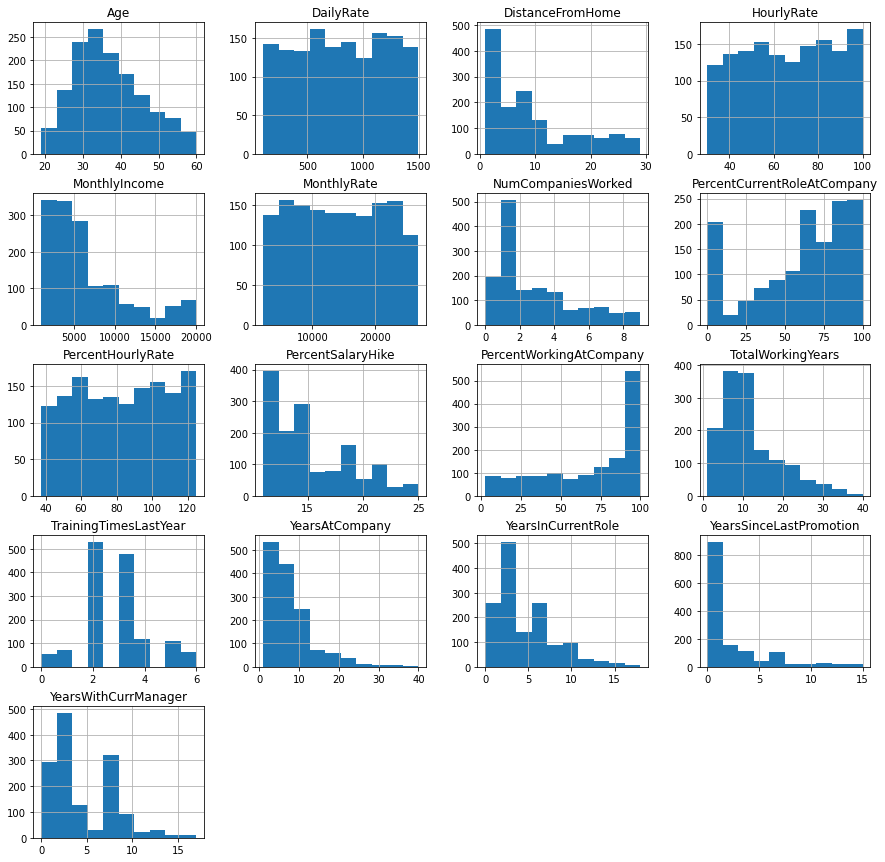

In [11]:
df[num_fea].hist(figsize=(15, 15))
plt.show()

## Categorical features

If there is a category with less than 0.05 of presence, then is an irrelevant category.

In [12]:
def normalize_discrete_values(df, feature, umbral = 0.05):
  aux = df[feature].value_counts(True).to_frame()
  aux['x'] = np.where(aux[feature] < umbral, 'Other', aux.index)
  if aux[aux['x'] == 'Other'][feature].sum() < umbral:
    aux['x'].replace({'Other' : aux.index[0]}, inplace=True)
  df[feature].replace(dict(zip(aux.index, aux.x)), inplace=True)
  return df

In [13]:
for fea in cat_fea:
  df = normalize_discrete_values(df, fea)

# Attribute relevance

## Continuous values to buckets

In [14]:
aux = df[num_fea].describe().T['max'] - df[num_fea].describe().T['min']
cut_features = aux[aux >= 6]
cut_features

Age                               41.000000
DailyRate                       1397.000000
DistanceFromHome                  28.000000
HourlyRate                        70.000000
MonthlyIncome                  18990.000000
MonthlyRate                    24905.000000
NumCompaniesWorked                 9.000000
PercentSalaryHike                 14.000000
TotalWorkingYears                 39.000000
TrainingTimesLastYear              6.000000
YearsAtCompany                    39.000000
YearsInCurrentRole                18.000000
YearsSinceLastPromotion           15.000000
YearsWithCurrManager              17.000000
PercentWorkingAtCompany           97.058824
PercentCurrentRoleAtCompany      100.000000
PercentHourlyRate                 87.500000
dtype: float64

In [15]:
range_to_int = dict()
int_to_range = dict()
for fea in cut_features.index:
  kb = KBinsDiscretizer(encode = 'ordinal', strategy = 'uniform')
  if cut_features[fea] < 10:
    kb.n_bins = 3
  elif cut_features[fea] < 50:
    kb.n_bins = 4
  else:
    kb.n_bins = 5
  df[fea] = kb.fit_transform(df[[fea]])
  ranges = ['%.2f|%.2f' % (a, b) for a, b in zip(kb.bin_edges_[0], kb.bin_edges_[0][1:])]
  int_to_range[fea] = dict(zip(range(len(ranges)), ranges))
  range_to_int[fea] = dict(zip(ranges, range(len(ranges))))
  df[fea].replace(int_to_range[fea], inplace=True)

## Weight of Evidence & Information Value
### WoE & IV

In [16]:
def get_woe_iv(df, feature, target):
  lst = []
  for val in df[feature].unique():
      lst.append({
          'Value': val,
          'All': len(df[df[feature] == val]),
          'Good': len(df[(df[feature] == val) & (df[target] == 0)]),
          'Bad': len(df[(df[feature] == val) & (df[target] == 1)])
      })
      
  dset = pd.DataFrame(lst)
  dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
  dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
  dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
  dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
  dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
  dset = dset.sort_values(by='WoE')
  
  return dset

In [17]:
iv_val = dict()
woe_val = dict()
for fea in cat_fea + num_fea:
  woe = get_woe_iv(df, fea, 'y')
  iv_val[fea] = woe['IV'].sum()
  woe_val[fea] = woe['WoE'].sum()
  print(fea)
  print(woe)
  print('WOE score: {:.2f}'.format(woe_val[fea]))
  print('IV score: {:.2f}'.format(iv_val[fea]))
  print()
iv_val = sorted(iv_val.items(), key=lambda item:item[1], reverse=True)

BusinessTravel
               Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE  \
1  Travel_Frequently   266   204   62    0.169295   0.280543 -0.505087   
0      Travel_Rarely  1017   869  148    0.721162   0.669683  0.074059   
2         Non-Travel   143   132   11    0.109544   0.049774  0.788835   

         IV  
1  0.056190  
0  0.003812  
2  0.047148  
WOE score: 0.36
IV score: 0.11

Department
                    Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE  \
0                   Sales  429   344   85    0.285477   0.384615 -0.298082   
1  Research & Development  997   861  136    0.714523   0.615385  0.149367   

         IV  
0  0.029551  
1  0.014808  
WOE score: -0.15
IV score: 0.04

Education
   Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
1      1  163   135   28    0.112033   0.126697 -0.123002  0.001804
3      3  600   502   98    0.416598   0.443439 -0.062440  0.001676
0      2  274   234   40    0.194191   0.180995  0.070370  0.0009

These are the most important features that can explain attrition.

In [18]:
iv = pd.DataFrame(iv_val, columns=['Feature', 'IV'])
iv = iv[iv['IV'] > 0.1]
iv_fea = iv['Feature']
iv

,Feature,IV
0,JobRole,0.447420
1,OverTime,0.377740
2,JobLevel,0.356117
3,StockOptionLevel,0.298445
4,MonthlyIncome,0.244740
5,MaritalStatus,0.180808
6,Age,0.170976
7,YearsInCurrentRole,0.150777
8,TotalWorkingYears,0.134760
9,JobInvolvement,0.127944


At this point, the dataframe only contains strings. For continouos features, the range is transform to an ordinal value. One hot encodign is applied to categorical features.

In [19]:
for fea in num_fea:
  df[fea].replace(range_to_int[fea], inplace=True)

cat_str_fea = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df = pd.concat([df, pd.get_dummies(df[cat_str_fea], drop_first=True)], axis=1, sort=False)
reverse_onehotencoding = df[cat_str_fea].copy()
df.drop(cat_str_fea, axis=1, inplace=True)
aux = [(x.split('_')[0] in list(iv_fea)) for x in df.columns]
iv_ohe_fea = df.columns[aux]

df = df.astype(float)
df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,y,PercentWorkingAtCompany,PercentCurrentRoleAtCompany,PercentHourlyRate,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Sales,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,2.0,3.0,0.0,2.0,2.0,4.0,3.0,2.0,4.0,1.0,3.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,2.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,4.0,0.0,3.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,4.0,0.0,4.0,4.0,1.0,3.0,1.0,3.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,1.0,0.0,3.0,1.0,2.0,0.0,2.0,2.0,0.0,3.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,3.0,0.0,2.0,4.0,3.0,3.0,1.0,4.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,4.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Model

In [20]:
X = df[iv_ohe_fea].copy()
y = df['y'].copy()

random_state = 760110
Xt, Xv, yt, yv = train_test_split(X, y, random_state = random_state)

Logistic regression is a powerful model for binary classification. Its interpretation is easy to understand.

In [21]:
model = LogisticRegression(C = 0.3, max_iter=len(Xt))
model.fit(Xt, yt)
print('roc_auc_score\t', roc_auc_score(yt, model.predict_proba(Xt)[:, 1]), roc_auc_score(yv, model.predict_proba(Xv)[:, 1]))
print('accuracy\t', accuracy_score(yt, model.predict(Xt)), accuracy_score(yv, model.predict(Xv)))
print('precision\t', precision_score(yt, model.predict(Xt)), precision_score(yv, model.predict(Xv)))
print('recall\t\t', recall_score(yt, model.predict(Xt)), recall_score(yv, model.predict(Xv)))
print('f1_score\t', f1_score(yt, model.predict(Xt)), f1_score(yv, model.predict(Xv)))

roc_auc_score	 0.8010096290578148 0.8284511590358666
accuracy	 0.862488306828812 0.865546218487395
precision	 0.7 0.8571428571428571
recall		 0.17177914110429449 0.20689655172413793
f1_score	 0.27586206896551724 0.33333333333333326


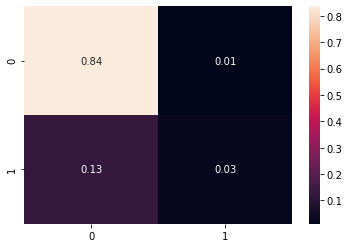

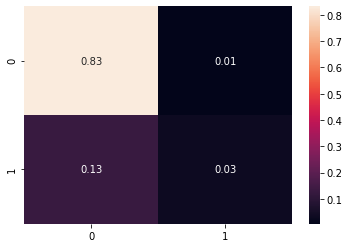

In [22]:
sns.heatmap(confusion_matrix(yt, model.predict(Xt)) / len(Xt), annot=True, fmt=".2f")
plt.show()
sns.heatmap(confusion_matrix(yv, model.predict(Xv)) / len(Xv), annot=True, fmt=".2f")
plt.show()

In [23]:
pd.DataFrame({'feature': iv_ohe_fea, 'coef': model.coef_[0]})

,feature,coef
0,Age,-0.210455
1,EnvironmentSatisfaction,-0.278537
2,JobInvolvement,-0.450798
3,JobLevel,-0.459436
4,MonthlyIncome,0.011605
5,StockOptionLevel,-0.269987
6,TotalWorkingYears,0.142794
7,YearsAtCompany,0.014700
8,YearsInCurrentRole,-0.075215
9,PercentCurrentRoleAtCompany,-0.228641


In [24]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

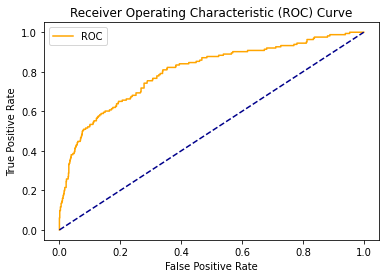

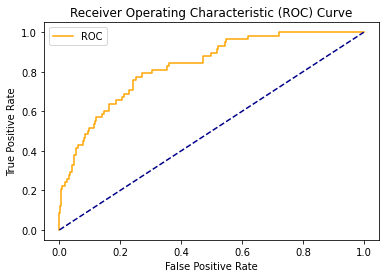

In [25]:
fpr, tpr, thresholds = roc_curve(yt, model.predict_proba(Xt)[:, 1])
plot_roc_curve(fpr, tpr)
fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(Xv)[:, 1])
plot_roc_curve(fpr, tpr)

# Scorecard

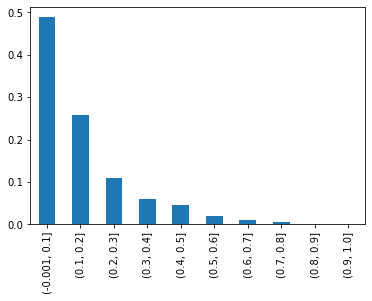

In [26]:
aux = Xt.copy()
aux['proba'] = model.predict_proba(aux)[:,1]
aux['proba'] = pd.cut(aux['proba'],include_lowest=True,bins=np.arange(0,1.1,0.1))
aux.proba.value_counts(True).sort_index().plot(kind='bar')

Instead of getting a probability, it is convenient to set points to every election of values.

In [27]:
pdo = 11.5  
base_score = 326 
base_odds = 1 
factor = float(pdo) / np.log(2)
offset = base_score - factor * np.log(base_odds)

n = len(iv_ohe_fea)
betas = model.coef_[0]
alpha = model.intercept_[0]
for feat, beta in zip(iv_ohe_fea, betas):
    aux['P_' + feat] = np.ceil((-aux[feat] * beta + alpha / n) * factor + offset / n).astype(int)
aux['score'] = aux[[f for f in aux.columns if f[:2] == 'P_']].sum(axis=1)
aux.score.describe()

count    1069.000000
mean      395.347053
std        19.321357
min       320.000000
25%       383.000000
50%       396.000000
75%       409.000000
max       453.000000
Name: score, dtype: float64

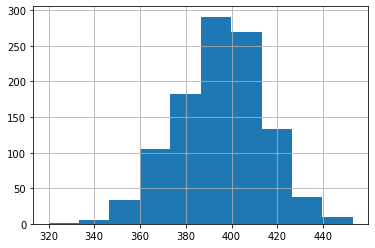

In [28]:
aux.score.hist()

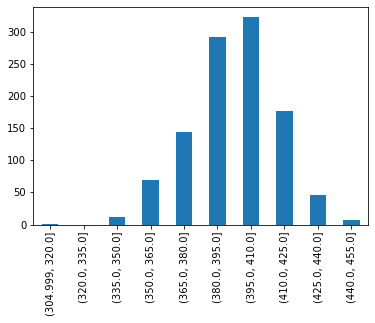

In [29]:
aux['r_score'] = pd.cut(aux.score, bins=range(min(aux.score) - 15,max(aux.score) + 15,15),include_lowest=True)
aux.r_score.value_counts().sort_index().plot(kind='bar')

The next table shows that with fewer points is more probable to get attrition as result.

In [30]:
aux['target']  = yt
aux['n']= 1.0
aux['r_score'] = aux['r_score'].astype(str)
aux['proba'] = aux['proba'].astype(str)
aux[['r_score','proba','target','n']].groupby(['r_score', 'proba', 'target']).sum()

n
r_score          proba         target       
(304.999, 320.0] (0.9, 1.0]    1.0       1.0
(335.0, 350.0]   (0.6, 0.7]    0.0       1.0
                               1.0       4.0
                 (0.7, 0.8]    1.0       6.0
(350.0, 365.0]   (0.4, 0.5]    0.0      18.0
                               1.0      24.0
                 (0.5, 0.6]    0.0       9.0
                               1.0      12.0
                 (0.6, 0.7]    0.0       2.0
                               1.0       5.0
(365.0, 380.0]   (0.2, 0.3]    0.0      59.0
                               1.0      13.0
                 (0.3, 0.4]    0.0      40.0
                               1.0      24.0
                 (0.4, 0.5]    0.0       2.0
                               1.0       6.0
(380.0, 395.0]   (0.1, 0.2]    0.0     211.0
                               1.0      36.0
                 (0.2, 0.3]    0.0      38.0
                               1.0       7.0
(395.0, 410.0]   (-0.001, 0.1] 0.0     280.0
                               1.0      13.0
                 (0.1, 0.2]    0.0      28.0
                               1.0       1.0
(410.0, 425.0]   (-0.001, 0.1] 0.0     167.0
                               1.0       9.0
(425.0, 440.0]   (-0.001, 0.1] 0.0      44.0
                               1.0       2.0
(440.0, 455.0]   (-0.001, 0.1] 0.0       7.0

If someone is filling a survey to detect attrition, it easier just to sum points than running a model.

In [31]:
for fea in [x for x in range_to_int.keys() if x in iv_ohe_fea]:
  aux[fea].replace(int_to_range[fea], inplace=True)

l_sc = []
for fea in iv_ohe_fea:
  aux2 = aux[[fea, 'P_%s' % fea]].copy().drop_duplicates().reset_index(drop=True)
  aux2.rename(columns={fea:'value','P_%s' % fea:'points'},inplace=True)
  aux2['feature'] = fea
  l_sc.append(aux2)

sc = pd.concat(l_sc,ignore_index=True)
sc = sc.groupby(['feature','value']).sum()
sc.reset_index()

,feature,value,points
0,Age,19.00|29.25,16
1,Age,29.25|39.50,19
2,Age,39.50|49.75,23
3,Age,49.75|60.00,26
4,BusinessTravel_Travel_Frequently,0,16
5,BusinessTravel_Travel_Frequently,1,4
6,BusinessTravel_Travel_Rarely,0,16
7,BusinessTravel_Travel_Rarely,1,12
8,EnvironmentSatisfaction,1,20
9,EnvironmentSatisfaction,2,25
